## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#Fix root
import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



Welcome to JupyROOT 6.12/04


/usr/local/Cellar/python/2.7.14_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("newoutputs/signalToys.npy")
sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]


### Calculate z values and chi squared 

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [5]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [6]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [7]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    #f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data with injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Gaussian Process signal-plus-background")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("background-only fit residuals",(2020,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("signal+background fit residuals",(2020,-3.5), fontsize=25)
    
    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)

    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [8]:
def makePrettyPlots_signalOnly(xs, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
   # f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='red',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
   # ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.set_ylim([-50, 75])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

    plt.show()

In [9]:
def makePrettyPlots_signalOnly2(xs, data, GPs, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, data, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Injected Signal")
    sigPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    #ax1.set_ylim([-3, 1.5*max(GPs)])
    ax1.set_ylim([-0.1, 40])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean function for GP

In [10]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### piecewise linear function for signal

In [11]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### right triangle function for signal

In [12]:
def triangle(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    offset=10.
    slope1 = amp/(2.*width-offset)
    y1 = amp*(-center+width)/(2*width-offset)
    slope2 = -amp/offset
    y2 = amp*(center+width)/offset
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width-offset: 
            output[i]=slope1*c+y1
        if c > center+width-offset and c < center+width:
            output[i]=slope2*c+y2
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [13]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [14]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [15]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [16]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

## OLD KERNEL

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [17]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian signals

parameters (300, 3500, 250)
(1.043664452516626, 1000.0000000000343, 119.1168486200982)
(449.89844678244873, 3581.7911193695386, 190.88783633112638)
(450.44602053559424, 3581.709793071464, 190.8240115444447)
(450.9910961924666, 3581.712540213539, 190.8020915063648)
A, mass, tau 450.991096192 3581.71254021 190.802091506


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.97967618009856


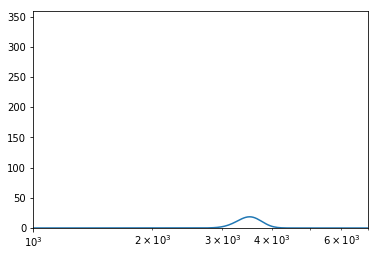

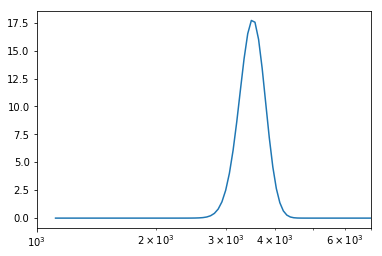

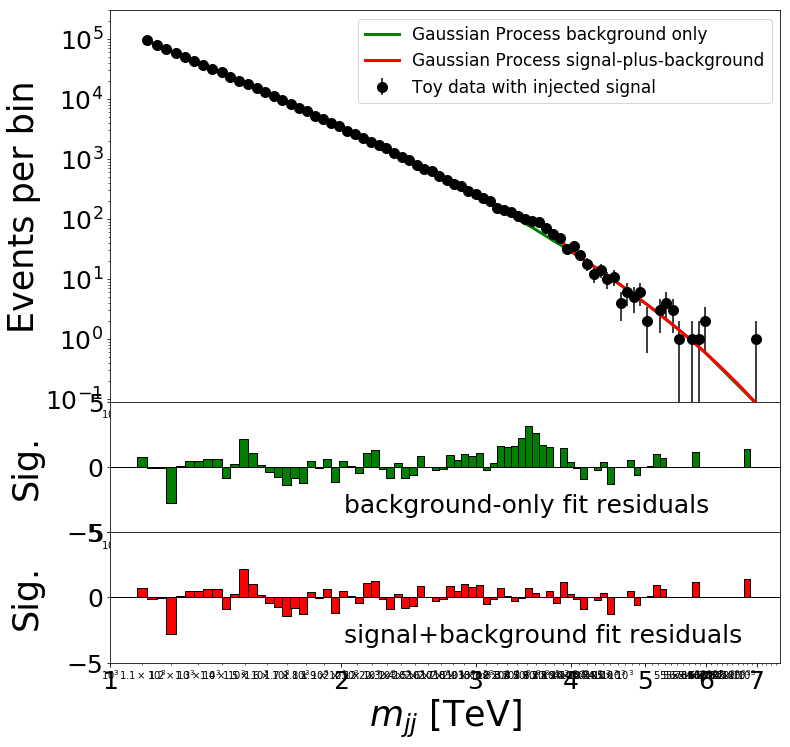

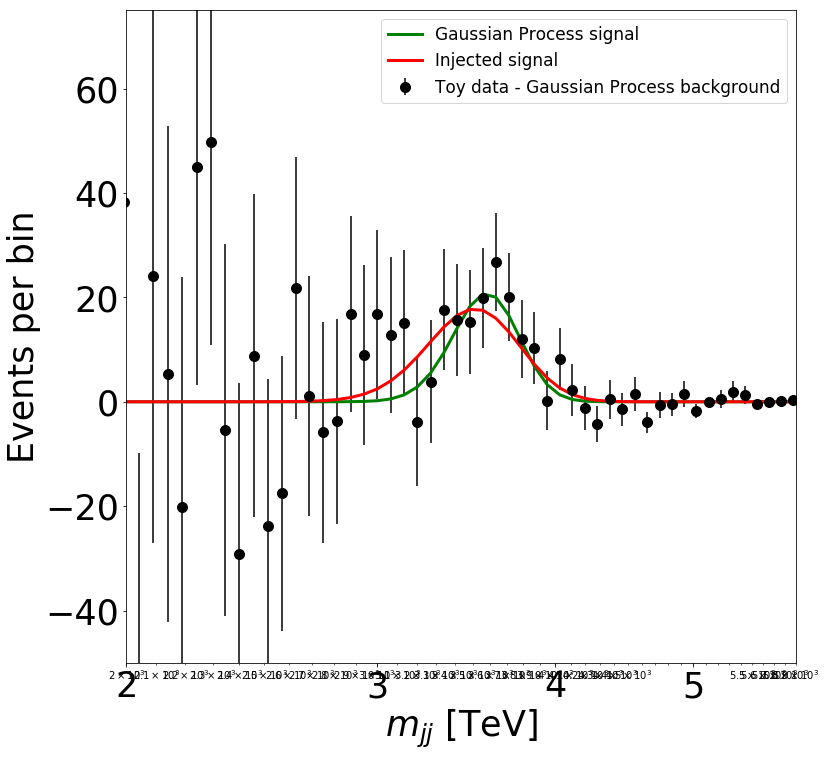

In [18]:
aa={}
mm={}
ww={}
#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        
        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)        
        

        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

### Peak signals

parameters (60, 3500, 250)
(609.712675748554, 3521.85837457571, 118.87968854159323)
A, mass, tau 609.712675749 3521.85837458 118.879688542
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 64.21357392630443


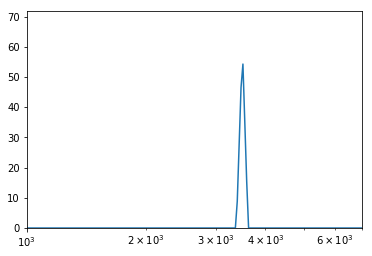

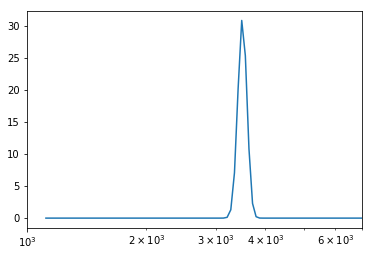

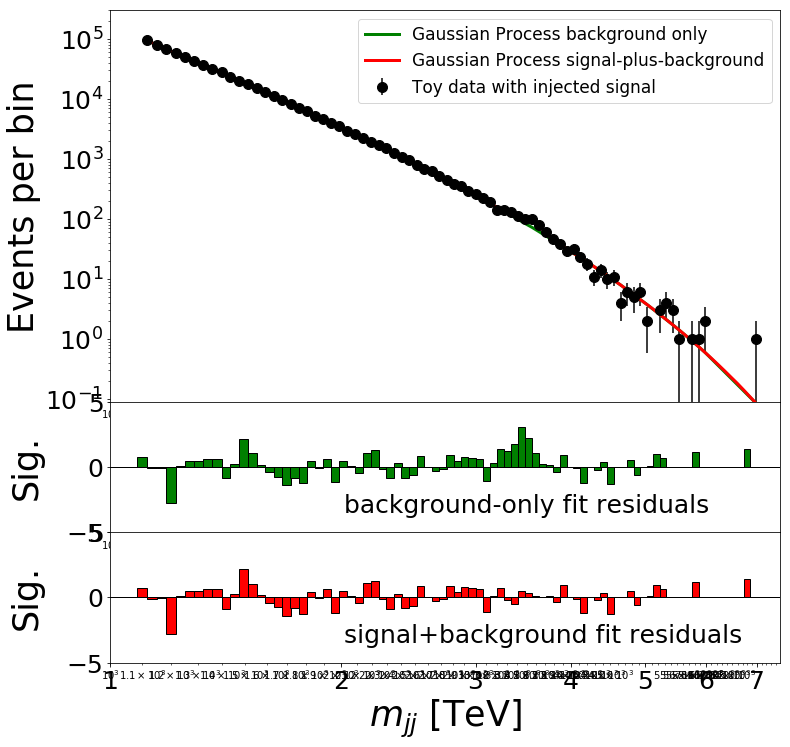

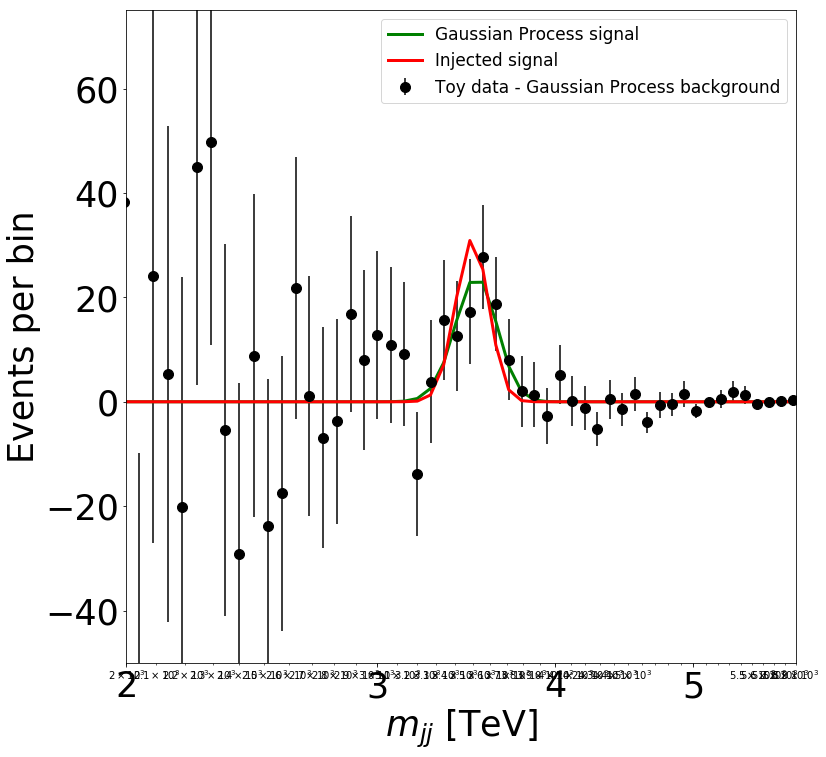

In [19]:
aa={}
mm={}
ww={}
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### square signals

parameters (20, 3500, 250)
(3615.4737866272335, 1510.3397127722387, 100.0000044175379)
(3235.301566428131, 1779.361955407679, 100.00000050609128)
(686.3190909560558, 3522.77212837524, 158.65932298969125)
(683.7059018134204, 3522.611918755104, 158.66052151546967)
(684.2061928177878, 3522.6042056243014, 158.67691281983852)
(684.9924504301554, 3522.597784326915, 158.63511833045644)
(684.8828327139663, 3522.5628751718723, 158.6780037956498)
A, mass, tau 684.882832714 3522.56287517 158.678003796


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 68.35215462749466


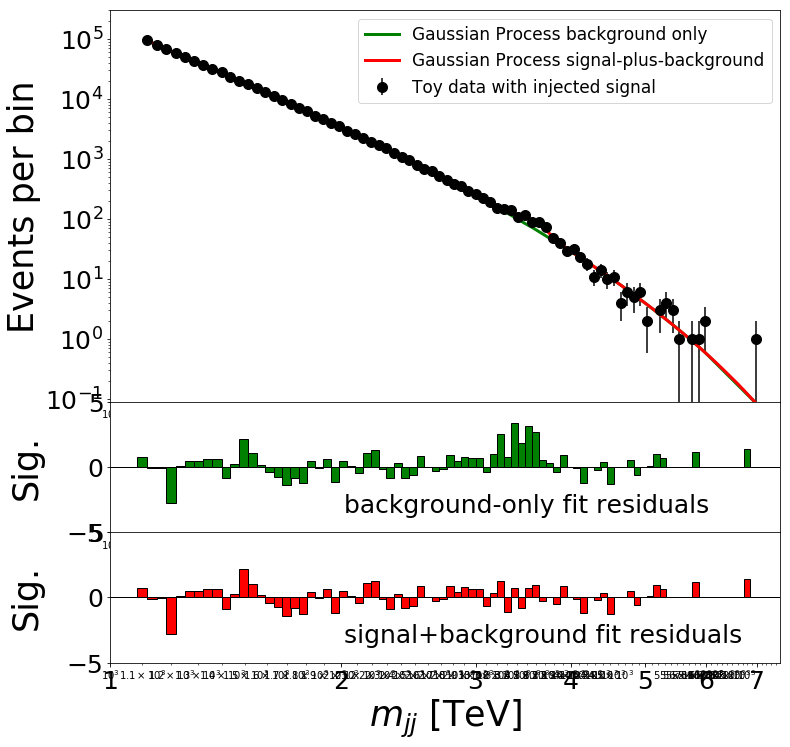

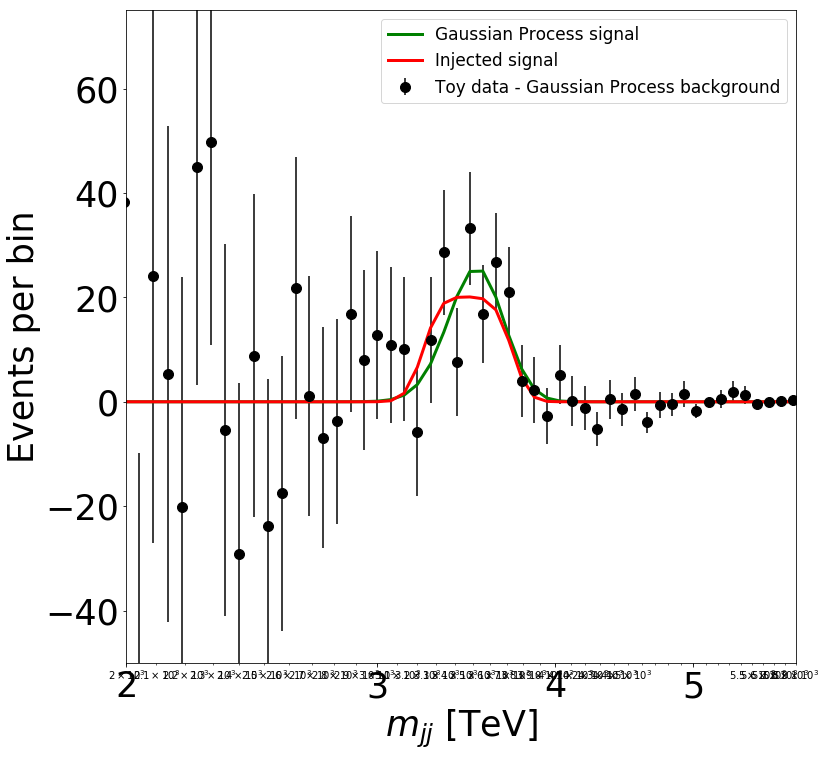

In [20]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### Right Triangle

parameters (40, 3520, 250)
(82.42376978565723, 2977.725803973591, 100.00013239320708)
(3202.2679043148646, 1779.3009000488003, 100.00000104823512)
(3234.6294157690613, 1779.3292305528907, 100.00002621745452)
(3236.495206779037, 1779.3530935588421, 100.00000094345587)
(1153.3109600712314, 3640.4732385580087, 123.20131069536986)
(1147.1945369726386, 3640.4997269517603, 123.06762059597168)
A, mass, tau 1147.19453697 3640.49972695 123.067620596


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 63.94097049937539


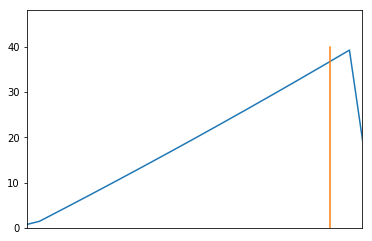

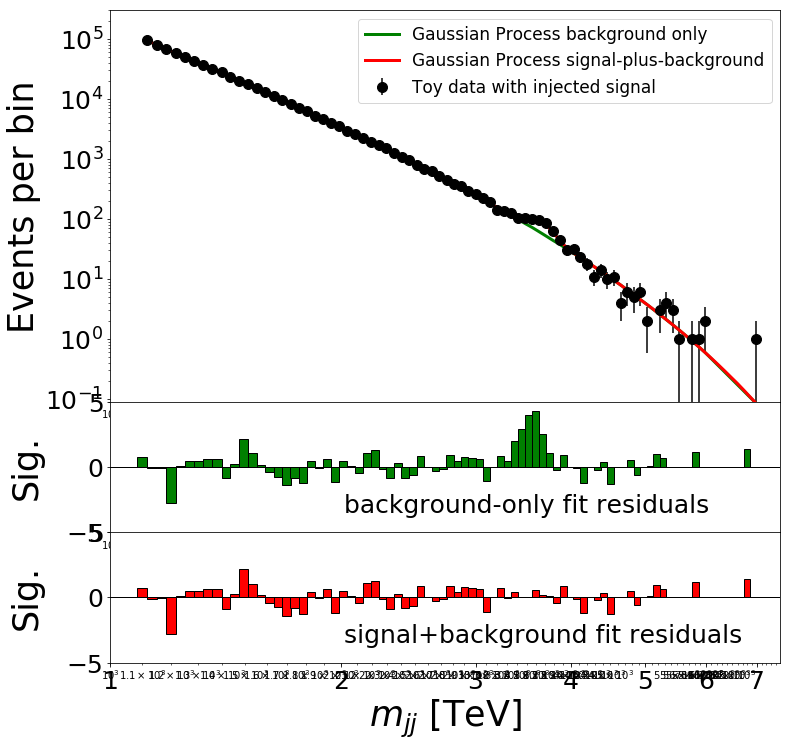

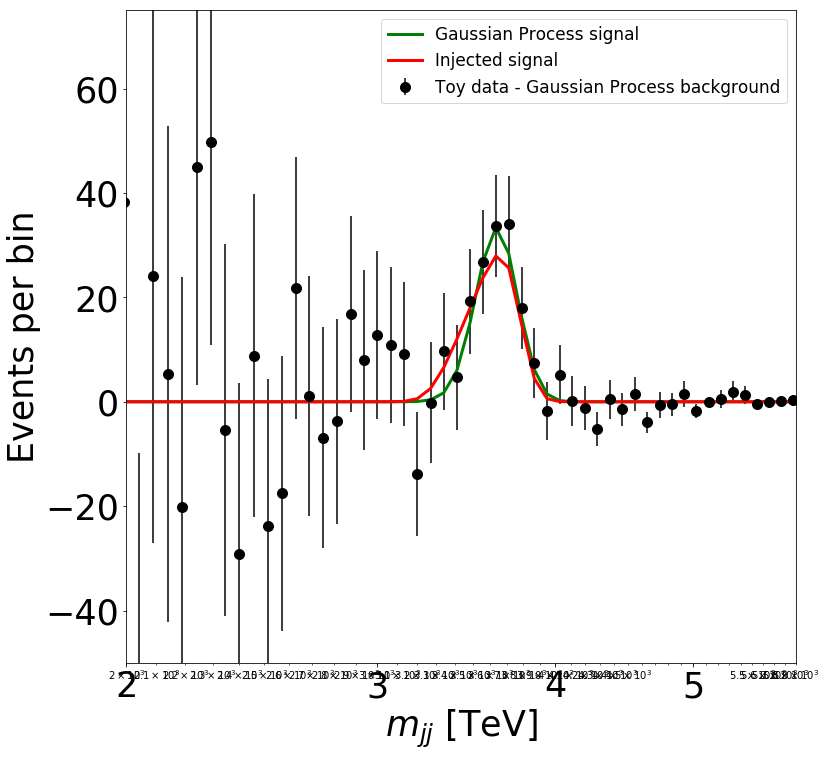

In [21]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## NEW SIGNAL KERNEL

In [22]:
class logLike_gp_fitgpsigNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams 
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsigNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L =1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (10, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(11319.14815003585, 1651.9210105910183, 125.44497358739623, 97.89144694854349)
(341.09759772978555, 3558.444680839741, 239.54452981965372, 9998.429041653162)
(340.8216507005584, 3558.322999312242, 239.5619876658847, 9999.797345251185)
A, mass, tau, L 340.821650701 3558.32299931 239.561987666 9999.79734525
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 65.58525496519046


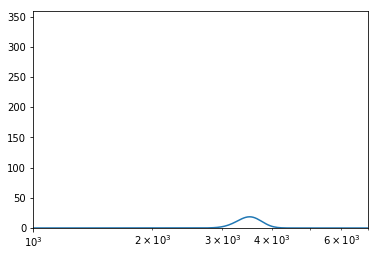

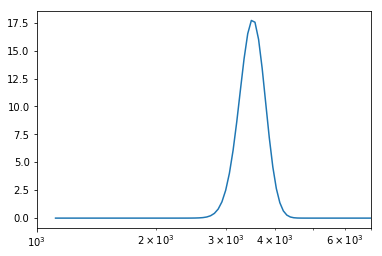

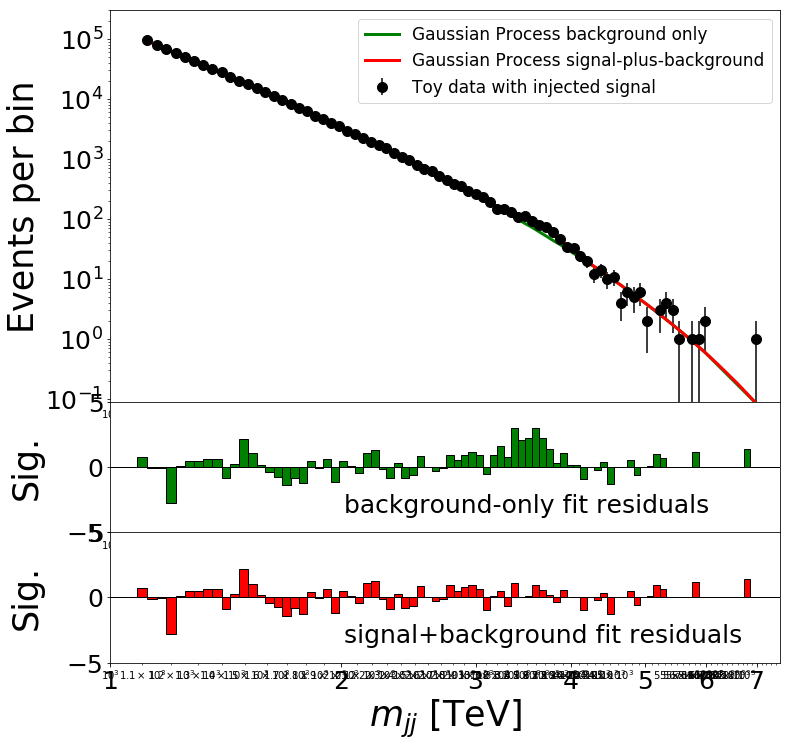

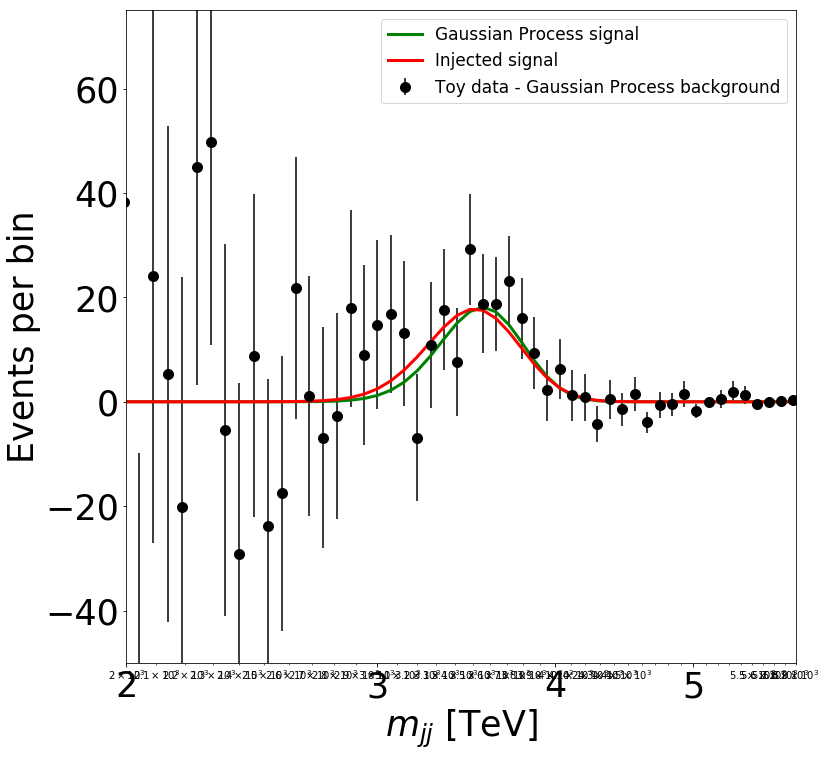

In [23]:
standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

### Peak Signal

parameters (60, 3500, 250)
(3.8234650025314063, 1000.0000000001716, 100.0, 39.48850312478634)
(11328.369051758362, 1651.954263595362, 125.44092420952163, 98.03402701646358)
(11352.437565242079, 1652.2427813947952, 125.32572957599051, 98.00032951969193)
(1199.4276608764446, 3552.2838901452646, 100.73725253836867, 9998.61062057609)
A, mass, tau, L 1199.42766088 3552.28389015 100.737252538 9998.61062058
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 63.73040259972945


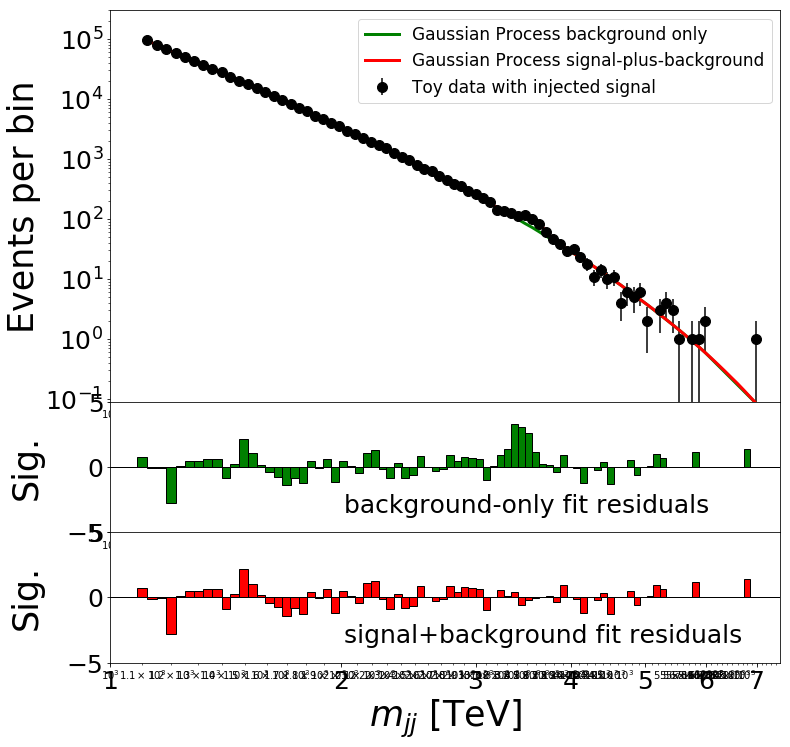

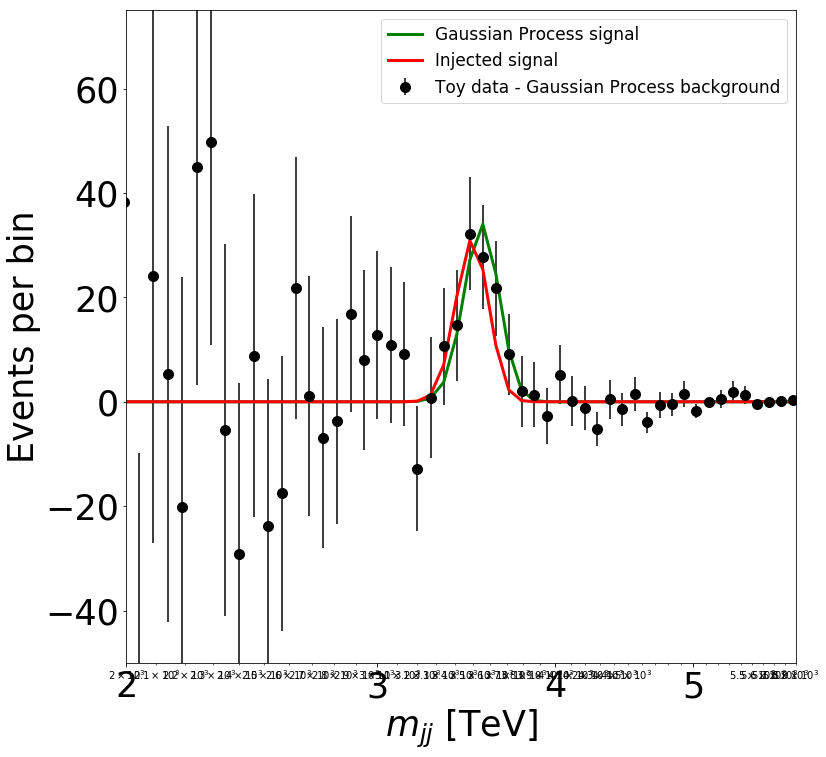

In [24]:
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)

        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)




### Square Signal

parameters (20, 3500, 250)
(11254.53560275413, 1651.774270860204, 125.63629515205528, 98.1377625869599)
(11342.228578296324, 1652.2315695196503, 125.38775736808749, 97.83585452177185)
(524.5607942790547, 3553.4012043598786, 159.72007145101233, 9997.773081984782)
(524.4621104700453, 3553.3638730977937, 159.6348493621038, 9995.611803025464)
(524.3893236185962, 3553.376138268636, 159.68158990867568, 9998.431521637061)
A, mass, tau, L 524.389323619 3553.37613827 159.681589909 9998.43152164
[3.12802545e-02 2.43933699e-02 1.89512117e-02 1.46678286e-02
 1.13098886e-02 8.65522069e-03 6.59874925e-03 5.01197348e-03
 3.77818502e-03 2.83740506e-03 2.12286861e-03 1.57634840e-03
 1.16612462e-03 8.59411935e-04 6.28615541e-04 4.58070692e-04
 3.32539744e-04 2.39597305e-04 1.71335604e-04 1.22061013e-04
 8.66303317e-05 6.10225434e-05 4.26616797e-05 2.96014453e-05
 2.04621631e-05 1.40913897e-05 9.63126713e-06 6.53341658e-06
 4.39870251e-06 2.93924746e-06 1.94928360e-06 1.28304308e-06
 8.38181550e-07 5.443

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 65.1361550363489


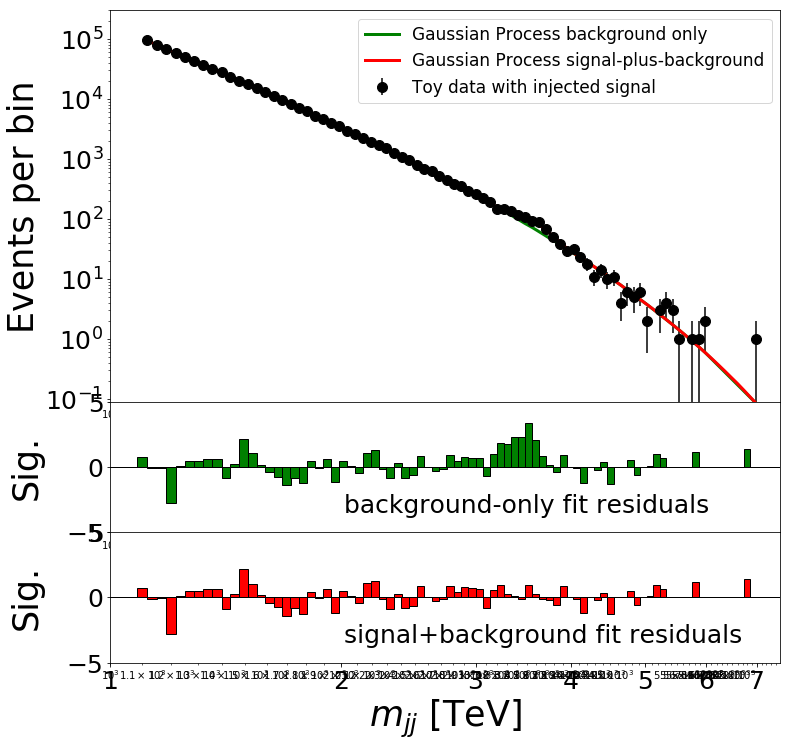

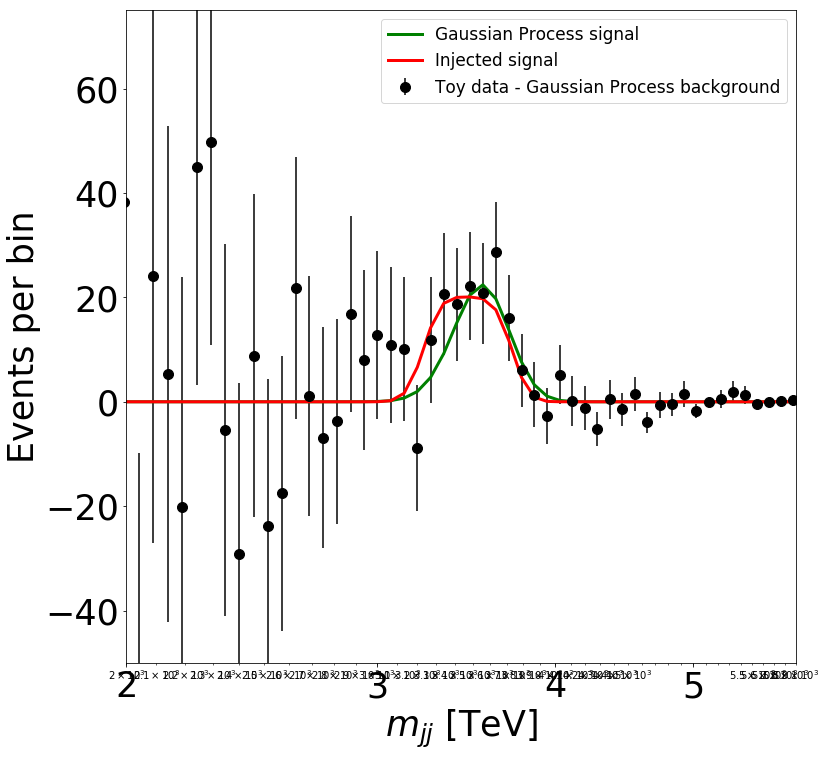

In [25]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)

        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
  
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        print np.sqrt(np.diag(covGP))
        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)





### Right Triangle

parameters (40, 3520, 250)
(29115.66278333021, 1230.8147462921465, 100.00000195878805, 16.003990014375393)
(1498.2844388524127, 3648.7071930831644, 127.59364414785992, 9990.267710621953)
(1503.1617851239448, 3648.735949925142, 127.5758521380196, 9999.102469813217)
A, mass, tau 1503.16178512 3648.73594993 127.575852138 9999.10246981
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 65.56158711578331


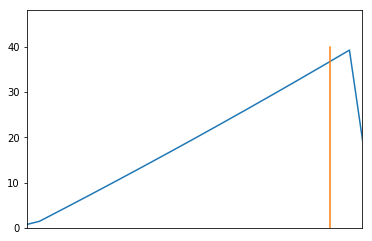

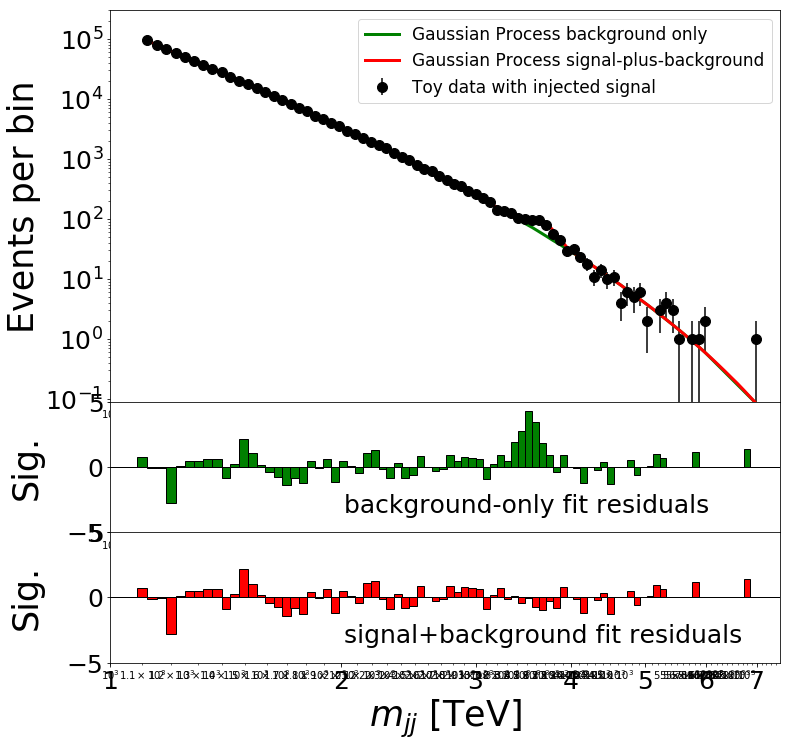

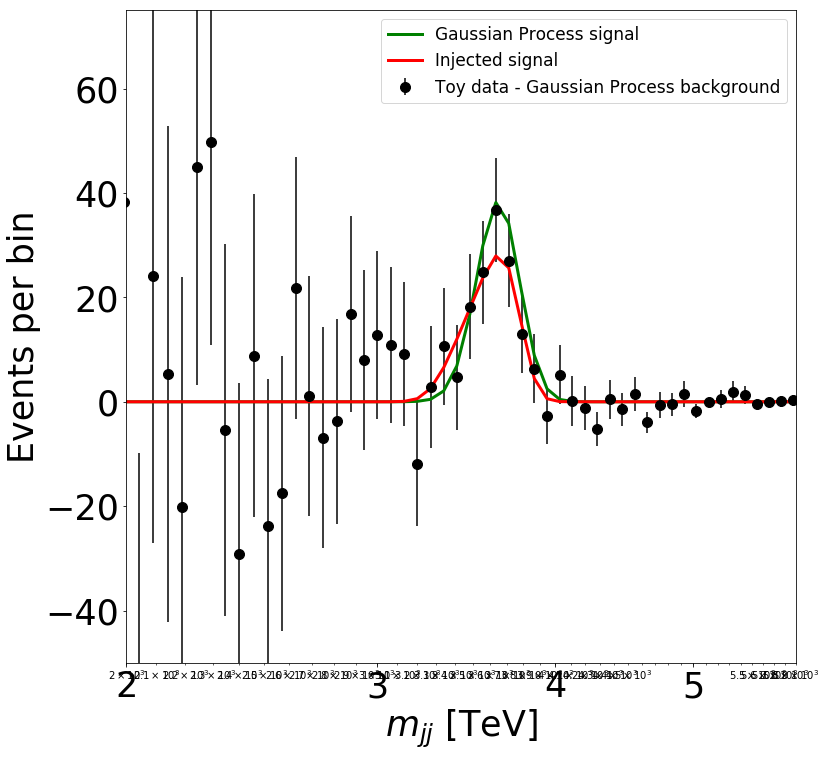

In [26]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## SIGNAL ONLY FIT

In [27]:
class logLike_gp_fitgpsigonlyNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L = L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonlyNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (100, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [28]:
class logLike_gp_fitgpsigonly:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonly_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(99.99990944849637, 2618.6869896162652, 100.00038148519445)
(99.99989619550306, 1000.0057220440796, 199.57833983659282)
(99.99994768584712, 3542.5552031530433, 103.82634749579151)
(99.99999998348142, 3542.554855826258, 103.82429290903765)
(99.99999994963092, 3542.5554140853833, 103.8241768362657)
A, mass, tau 99.9999999496 3542.55541409 103.824176836
[6.98802376e-119 1.11674386e-115 1.79976234e-112 2.91148534e-109
 4.70540676e-106 8.39498747e-103 1.47701729e-099 2.54987060e-096
 4.74720705e-093 8.55386633e-090 1.48386544e-086 2.70830240e-083
 4.69053594e-080 7.66572291e-077 1.28432045e-073 1.99982322e-070
 2.87719654e-067 4.12944889e-064 5.84119334e-061 7.43667916e-058
 8.46847041e-055 9.23053267e-052 9.50657520e-049 9.12968414e-046
 7.54038641e-043 5.31956832e-040 3.38980227e-037 1.92390549e-034
 9.58693608e-032 4.13349227e-029 1.51924995e-026 4.68844549e-024
 1.19621135e-021 2.48391870e-019 4.13111589e-017 5.41411143e-015
 5.49952539e-013 4.25744431e-011 2

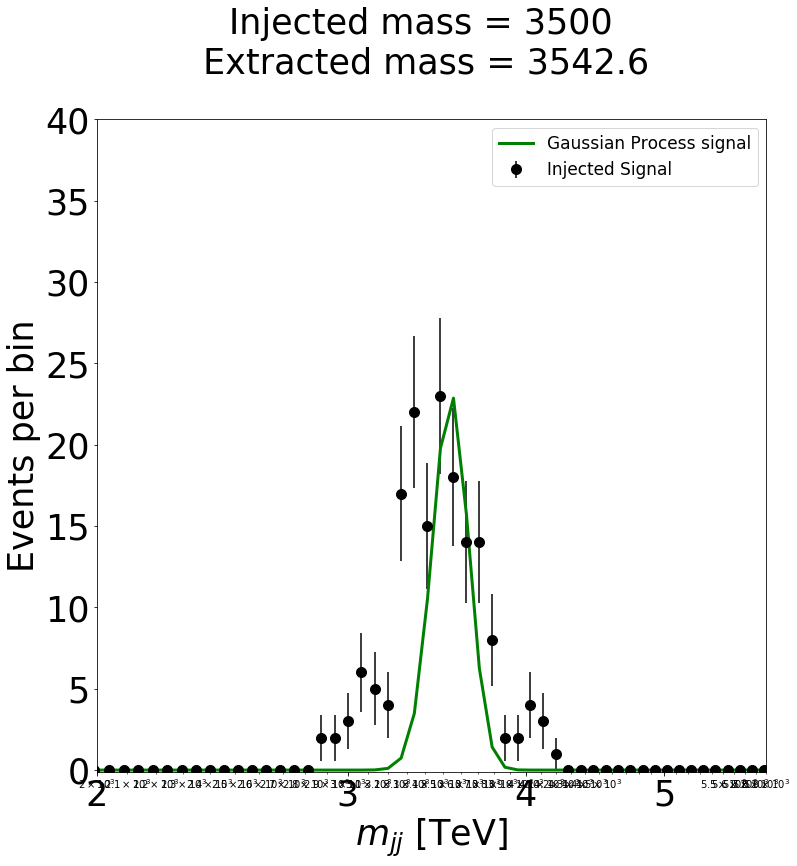

(99.99999959756589, 3542.585919495482, 103.82656318731863, 9992.482944148549)
(99.9999817792028, 3542.5536611614298, 103.82937423294175, 9987.059529138027)
A, mass, tau 99.9999817792 3542.55366116 103.829374233 9987.05952914
[9.65761483e-119 1.53314140e-115 2.45424996e-112 3.94326490e-109
 6.32906989e-106 1.12120636e-102 1.95857381e-099 3.35682503e-096
 6.20341481e-093 1.10945006e-089 1.91013777e-086 3.45958514e-083
 5.94541941e-080 9.64106335e-077 1.60249461e-073 2.47542781e-070
 3.53305650e-067 5.02973482e-064 7.05635626e-061 8.91009326e-058
 1.00631680e-054 1.08780477e-051 1.11100690e-048 1.05802904e-045
 8.66581118e-043 6.06312002e-040 3.83177098e-037 2.15687232e-034
 1.06599643e-031 4.55888088e-029 1.66217433e-026 5.08903309e-024
 1.28836471e-021 2.65504319e-019 4.38326653e-017 5.70376841e-015
 5.75423596e-013 4.42567092e-011 2.55105542e-009 1.08311192e-007
 3.32799279e-006 7.26891223e-005 1.10824613e-003 1.15788036e-002
 8.23945514e-002 3.88021447e-001 1.16723335e+000 2.19876850e

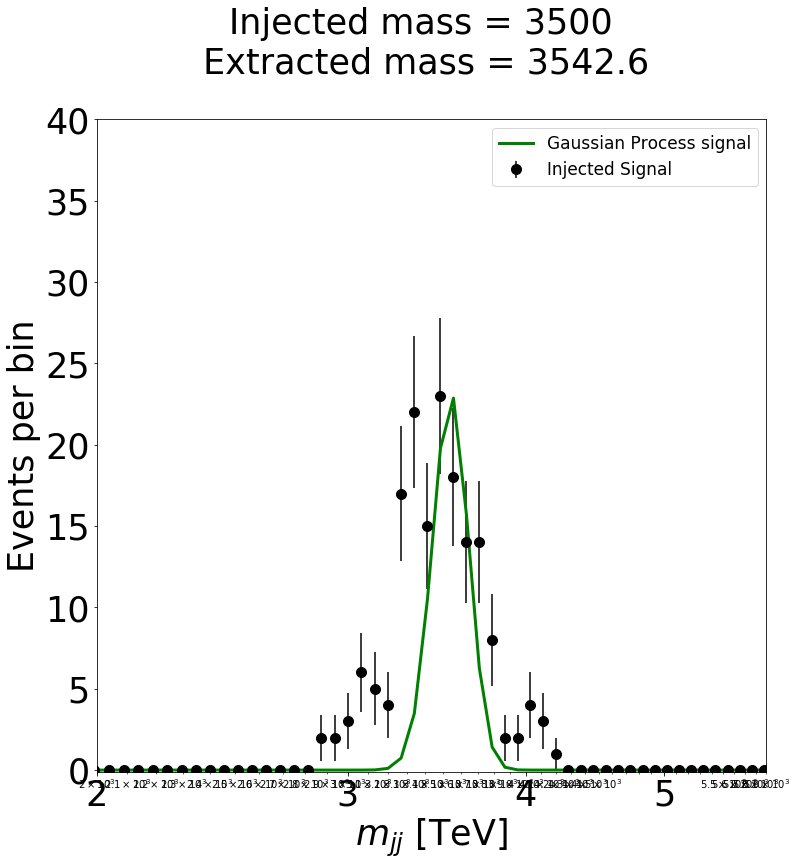

In [29]:

standardParamSets=[(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)
        ####################################################################################

        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
            
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Peak Signal

parameters (60, 3500, 250)
(99.99993646974282, 1000.0056979212235, 115.31446105413062)
(99.99842372335216, 6486.9865115195535, 100.00000000087739)
(1.0000005980319209, 6486.971225849492, 100.00000043394283)
(1.0000000001987814, 6487.000488535418, 100.00000004279515)
(1.0000000005153833, 6487.000052610892, 100.0)
(1.0000000000017641, 6486.999821378644, 100.00000000000011)
(1.0000000000008464, 6487.000158618475, 100.00000000002065)
A, mass, tau 1.0 6487.00015862 100.0
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.000000

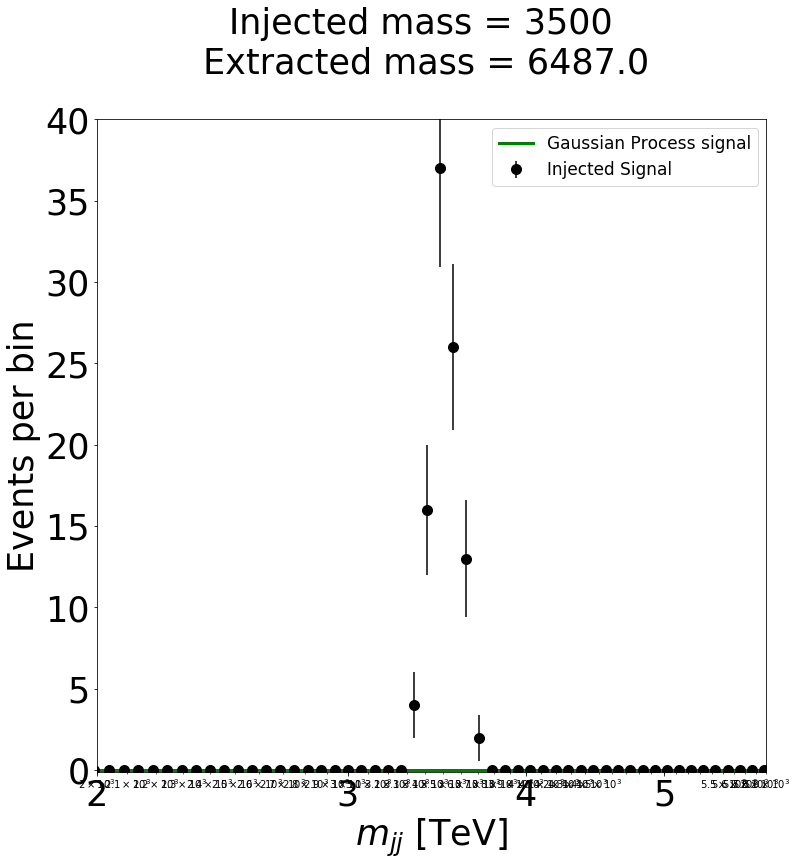

(1.0000001572023616, 1000.0000626607772, 100.00001949490797, 9999.998867055265)
(1.0000016989187825, 6487.011328626696, 100.0000107519796, 9999.382468229263)
(1.000002020531584, 6487.001767215802, 100.00000004467051, 9999.953958304946)
(1.0000000247867895, 6486.994724542816, 100.0000007397473, 9999.972948264483)
(1.0000003324405096, 6487.002263212739, 100.00000048328359, 9999.997821253564)
(1.000000000001687, 6486.999998442187, 100.00000000000277, 9999.997845463768)
(1.000000000001687, 6486.999998442187, 100.00000000000277, 9999.997845463768)
A, mass, tau 1.0 6486.99999844 100.0 9999.99784546
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.0000000

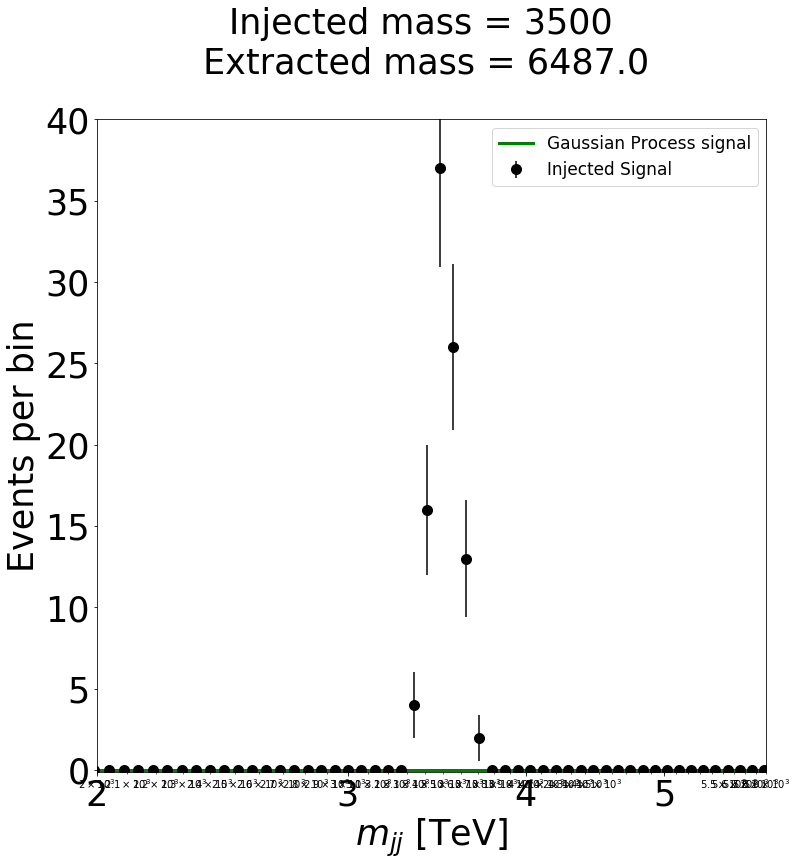

In [30]:
standardParamSets = [(60, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        #########################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Square Signal

parameters (20, 3500, 250)
(99.99986672512163, 1000.0029948141834, 100.00040995390155)
(1.0000000491997518, 1000.0000051085849, 100.00000009112323)
(1.0000000000433438, 6487.000104499443, 100.00000000014369)
A, mass, tau 1.00000000004 6487.0001045 100.0
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+00

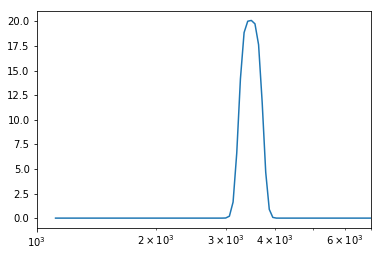

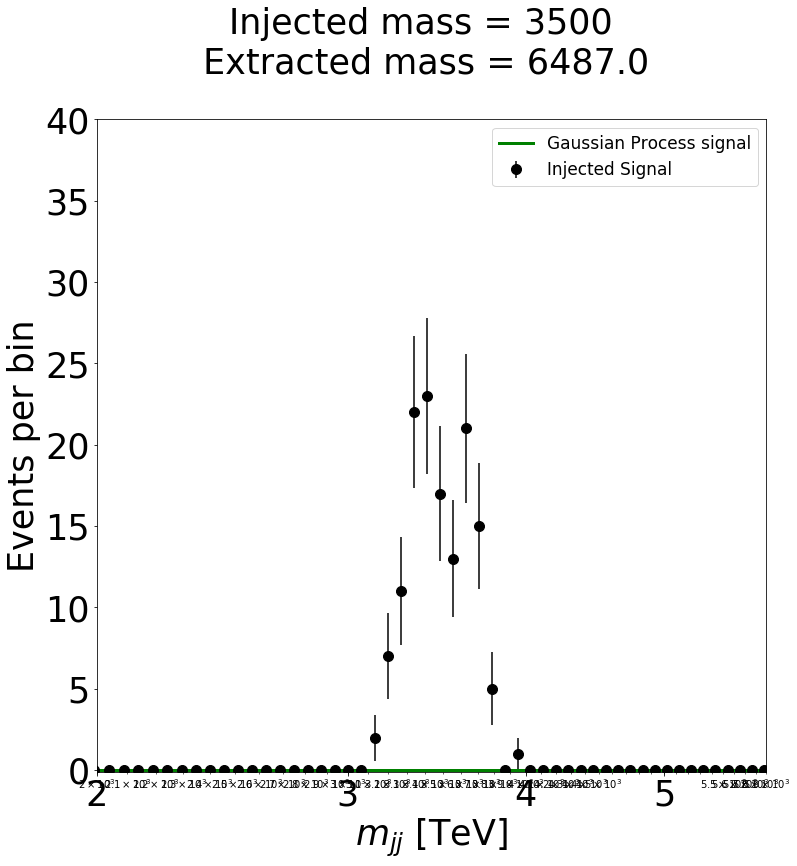

(99.99902968938248, 3536.5285550132676, 100.00000069600546, 158.45360828291058)
(99.99975572037938, 3536.608059015776, 100.00000020309334, 158.23216596069543)
(99.99999936005916, 3536.523280544848, 100.0000000014542, 158.29441065261292)
(99.99999987817802, 3536.527820358502, 100.00000000356111, 158.29416789907415)
(99.99999987817802, 3536.527820358502, 100.00000000356111, 158.29416789907415)
A, mass, tau 99.9999998782 3536.52782036 100.000000004 158.294167899
[6.71376139e-127 1.86910703e-123 5.24951773e-120 1.47992355e-116
 4.16657197e-113 1.30419960e-109 4.02021101e-106 1.21380258e-102
 3.97309191e-099 1.25509335e-095 3.80465107e-092 1.21753863e-088
 3.68101049e-085 1.04510996e-081 3.04597114e-078 8.20120705e-075
 2.02713144e-071 4.99443827e-068 1.21066631e-064 2.61899534e-061
 5.02210712e-058 9.18100041e-055 1.57793251e-051 2.51357891e-048
 3.40225566e-045 3.88436131e-042 3.97174794e-039 3.58239575e-036
 2.80663162e-033 1.88008322e-030 1.05968730e-027 4.94404518e-025
 1.87768673e-022

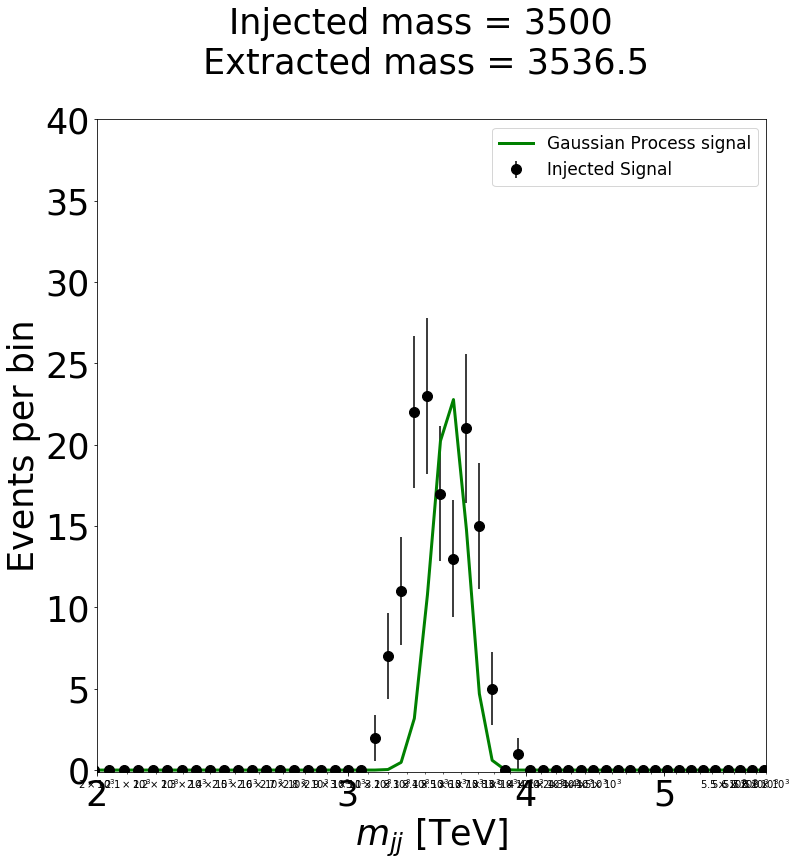

In [31]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)
        

### Right Triangle

parameters (40, 3520, 250)
(99.99990558627267, 1000.0036379156867, 101.39152749330778)
(99.99998006812119, 3616.904798885581, 229.35080942565637)
(1.0000013743734995, 1000.0000668462902, 100.0001607002873)
(1.0000000058293246, 6486.999910902577, 100.0000000023449)
(1.0000000000093645, 6487.000263058965, 100.00000000000074)
A, mass, tau 1.00000000001 6487.00026306 100.0
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000

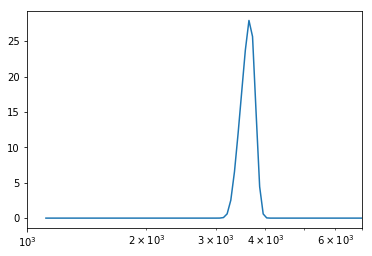

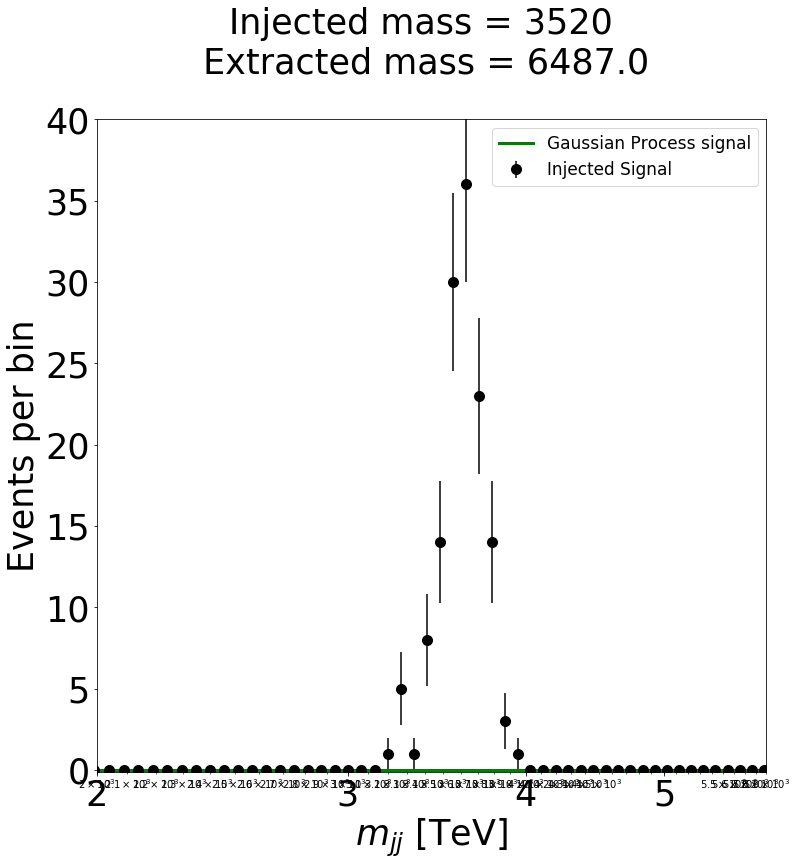

(1.0000000008821215, 6486.998559895271, 100.00000006725224, 9999.99923540441)
(99.99971838562762, 3619.513546417436, 100.0000024506114, 152.94042389334297)
(99.99992546331565, 3619.4437154984125, 100.00000014652832, 152.91169728498397)
(99.99999554794536, 3619.45752629028, 100.00000001741476, 152.84913102864894)
(99.99999414838254, 3619.4704579440477, 100.00000000004961, 152.82977481052694)
(99.99999998514684, 3619.471034498708, 100.00000000000027, 152.82685118059214)
(99.99999998514684, 3619.471034498708, 100.00000000000027, 152.82685118059214)
A, mass, tau 99.9999999851 3619.4710345 100.0 152.826851181
[9.12445127e-136 3.34000333e-132 1.23852592e-128 4.62912626e-125
 1.73505712e-121 7.29048248e-118 3.02928034e-114 1.23799295e-110
 5.53070384e-107 2.39447654e-103 9.98925831e-100 4.43595560e-096
 1.86878190e-092 7.42406490e-089 3.05278308e-085 1.16449979e-081
 4.09483224e-078 1.44722348e-074 5.07423210e-071 1.59433144e-067
 4.45891255e-064 1.19876559e-060 3.05517534e-057 7.27689111e-05

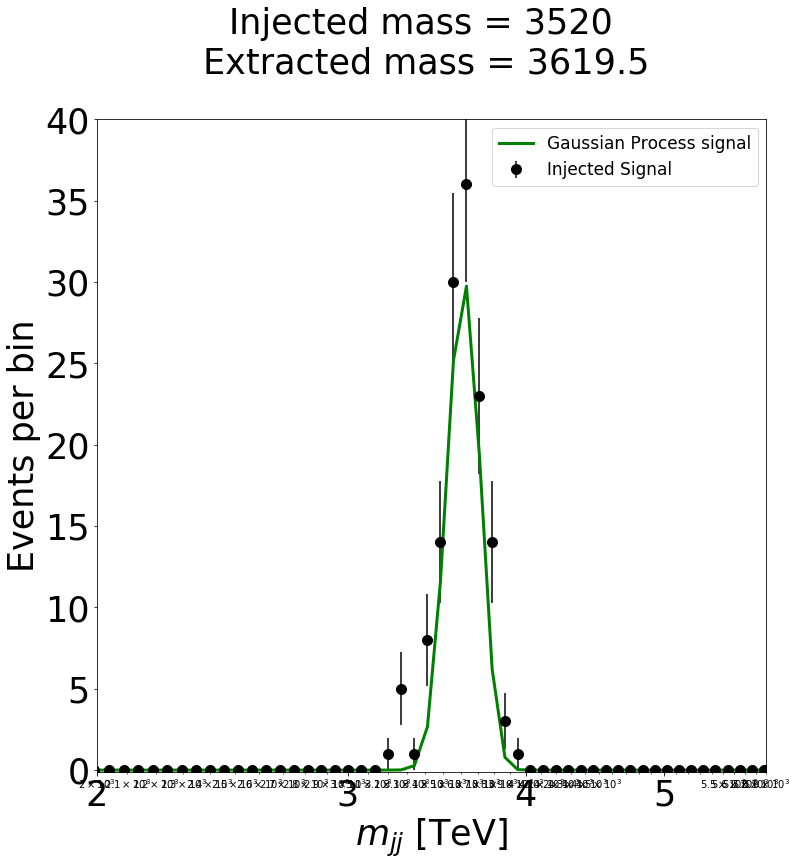

In [32]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        
        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)


        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

## NO SMEARING OR NOISE ON SIGNAL

parameters (20, 3500, 250)
(3735.9505901566104, 1759.123665786125, 100.00000025532121, 112.86174901499501)
(742.990039639023, 3544.2574750812064, 156.78901282025342, 9991.749601039404)
(743.1548288168943, 3544.22322853884, 156.7897720052746, 9993.691730068038)
(742.6510375065134, 3544.208646354861, 156.8163214782101, 9999.285635404047)
A, mass, tau, L 742.651037507 3544.20864635 156.816321478 9999.2856354
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 69.05285816307642


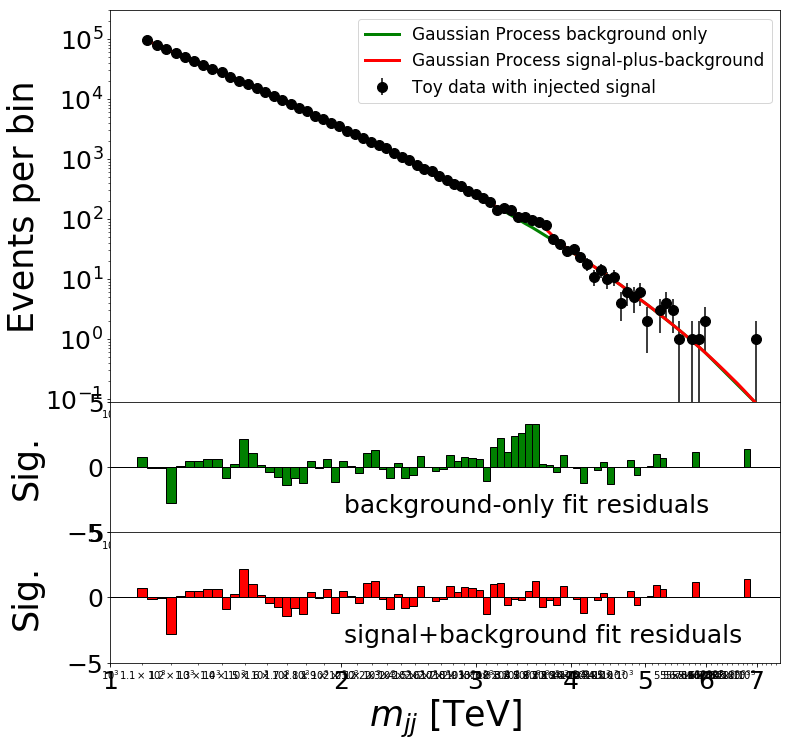

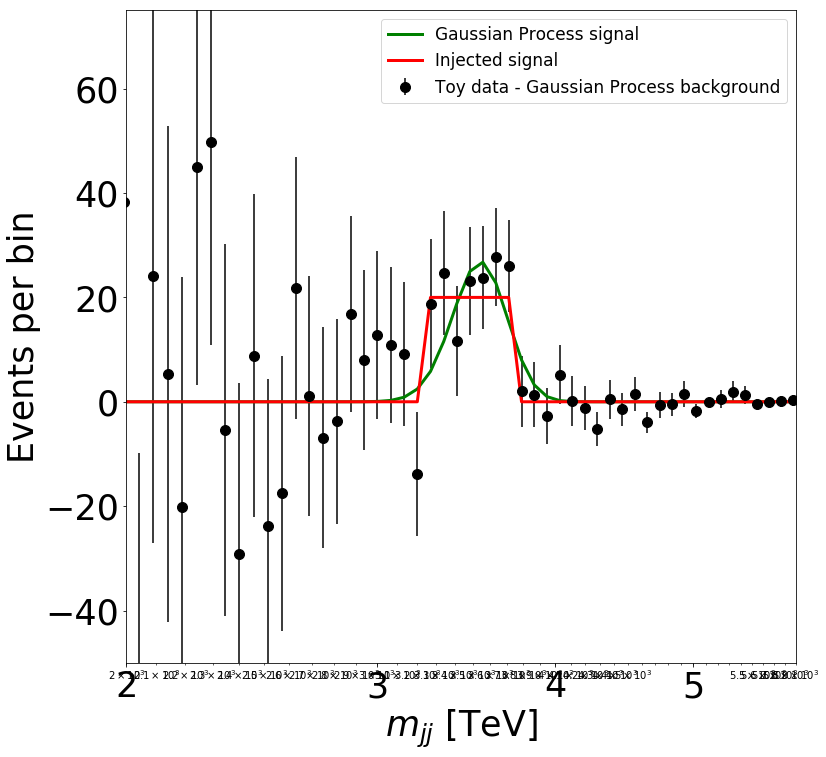

In [33]:


standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(xtoy, n, m, w, xtoyerr)
        ydata = signal+ytoy
        
        signalO = square(xvalO, n, m, w, xerrO)
        ydataO = yvalO+signalO
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        #makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        